In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, f1_score
import lightgbm as lgb
from collections import Counter
import warnings
import pickle
from catboost import CatBoostClassifier
warnings.filterwarnings("ignore")

In [4]:
import numba
from numba import jit

In [4]:

def model_fit1(X_train, y_train):
    categorical_features_indices = [ 0,  2,  3,  6, 15, 16, 19, 28, 29, 32, 41, 42, 45, 54, 55, 58, 67, 68, 71, 72, 73, 74, 75, 76, 78, 79]
    model = CatBoostClassifier(iterations=300, depth=5,cat_features=categorical_features_indices,learning_rate=0.5, loss_function='Logloss',
                            logging_level='Verbose')
    model.fit(X_train,y_train,eval_set=(X_train, y_train))
    return model

### time

In [7]:
train = pd.read_csv('train/is_train_20190701.txt')
# train = pd.merge(train[['link','current_slice_id','future_slice_id']][(train.future_slice_id <= 50)],train,how='left') 


In [9]:
train1 = pd.read_csv('train/is_train_201907'+str(16)+'.txt')
train = train.append(train1)

In [10]:
pro = pd.read_csv('per_road_pro.txt')

In [11]:
# train = pd.read_csv('is_train_data/is_train_20190723.txt')
train = pd.merge(train, pro, how='left')

In [12]:
train = train.drop('pro_0',1)
train = train.drop('pro_1',1)
train = train.drop('pro_2',1)

In [13]:
y = train.label
train = train.drop('label',1)

### 过采样

In [23]:
from imblearn.over_sampling import RandomOverSampler
 
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(train, y)

### 下采样

In [33]:
from imblearn.under_sampling import RandomUnderSampler
 
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_sample(train, y)

In [34]:
X_resampled

,link,current_slice_id,future_slice_id,time_diff,now_speed,now_eta,now_cnt,now_state,current_speed_min,current_speed_max,...,his_7_cnt_min,his_7_cnt_max,his_7_cnt_mean,his_7_cnt_std,his_7_state_zhong,his_7_state_max,his_7_state_min,pro_0,pro_1,pro_2
0,99946,23,47,24,24.6,28.8,1,1,24.593750,35.812500,...,1,1,1.0,0.000000,0,0,9,0.946605,0.049440,0.003955
1,277552,28,47,19,45.7,25.8,82,1,39.500000,45.687500,...,37,46,42.2,3.919184,1,1,1,0.593872,0.252368,0.153760
2,211945,-3,10,13,35.6,31.5,1,1,35.593750,35.593750,...,1,1,1.0,0.000000,1,1,1,0.990909,0.004545,0.004545
3,223275,-11,12,23,20.9,23.2,9,1,20.906250,23.500000,...,7,13,10.6,2.576820,1,1,1,0.585185,0.346439,0.068376
4,510868,14,19,5,38.0,22.7,4,1,35.093750,40.812500,...,2,6,2.8,1.600000,1,1,1,0.688446,0.084594,0.226960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7186,353695,17,32,15,2.8,3.9,8,4,2.699219,3.800781,...,9,12,11.4,1.200000,1,1,1,0.709715,0.101222,0.189063
7187,353695,-12,10,22,3.5,8.4,16,4,3.500000,5.300781,...,9,12,10.2,1.166190,1,1,1,0.709715,0.101222,0.189063
7188,310394,14,19,5,14.8,9.7,25,2,14.796875,32.593750,...,24,29,25.6,1.854724,1,1,1,0.528627,0.372985,0.098388
7189,34456,27,44,17,9.3,16.1,10,3,9.203125,21.000000,...,5,10,8.0,1.788854,3,3,2,0.650435,0.274783,0.074783


In [29]:
train = train.drop('current_speed_min',1)
train = train.drop('current_eta_min',1)
train = train.drop('current_cnt_min',1)
train = train.drop('current_state_min',1)

train = train.drop('his_28_speed_min',1)
train = train.drop('his_28_eta_min',1)
train = train.drop('his_28_cnt_min',1)
train = train.drop('his_28_state_min',1)

train = train.drop('his_21_speed_min',1)
train = train.drop('his_21_eta_min',1)
train = train.drop('his_21_cnt_min',1)
train = train.drop('his_21_state_min',1)

train = train.drop('his_14_speed_min',1)
train = train.drop('his_14_eta_min',1)
train = train.drop('his_14_cnt_min',1)
train = train.drop('his_14_state_min',1)

train = train.drop('his_7_speed_min',1)
train = train.drop('his_7_eta_min',1)
train = train.drop('his_7_cnt_min',1)
train = train.drop('his_7_state_min',1)

In [16]:
s = train.columns.values

In [15]:
train_1 = pd.read_csv('train//is_train_20190730.txt')
y_5 = train_1.label
train_1 = pd.merge(train_1, pro, how='left')
train_1 = train_1.drop('label',1)

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(train,y,test_size=0.2 , random_state=1234)
classweight = {0:0.4,1:0.4,2:0.2}

model = CatBoostClassifier(iterations=200,depth=6,l2_leaf_reg=8,learning_rate=0.5,random_strength=1,
                                      loss_function='MultiClassOneVsAll',logging_level='Verbose')

model.fit(X_train,y_train,eval_set=(X_validation,y_validation))

0:	learn: 0.4223501	test: 0.4220385	best: 0.4220385 (0)	total: 288ms	remaining: 57.3s
1:	learn: 0.3225197	test: 0.3221521	best: 0.3221521 (1)	total: 604ms	remaining: 59.8s
2:	learn: 0.2751578	test: 0.2747380	best: 0.2747380 (2)	total: 902ms	remaining: 59.2s
3:	learn: 0.2516520	test: 0.2513104	best: 0.2513104 (3)	total: 1.2s	remaining: 58.8s
4:	learn: 0.2392438	test: 0.2389070	best: 0.2389070 (4)	total: 1.48s	remaining: 57.7s
5:	learn: 0.2322799	test: 0.2319286	best: 0.2319286 (5)	total: 1.77s	remaining: 57.4s
6:	learn: 0.2278401	test: 0.2274919	best: 0.2274919 (6)	total: 2.11s	remaining: 58.3s
7:	learn: 0.2254510	test: 0.2252003	best: 0.2252003 (7)	total: 2.43s	remaining: 58.4s
8:	learn: 0.2239067	test: 0.2236900	best: 0.2236900 (8)	total: 2.71s	remaining: 57.6s
9:	learn: 0.2229173	test: 0.2227036	best: 0.2227036 (9)	total: 2.99s	remaining: 56.7s
10:	learn: 0.2221408	test: 0.2219124	best: 0.2219124 (10)	total: 3.29s	remaining: 56.6s
11:	learn: 0.2217154	test: 0.2214892	best: 0.2214892 

94:	learn: 0.2117265	test: 0.2142306	best: 0.2142306 (94)	total: 28.6s	remaining: 31.6s
95:	learn: 0.2116573	test: 0.2141897	best: 0.2141897 (95)	total: 28.9s	remaining: 31.3s
96:	learn: 0.2115604	test: 0.2141358	best: 0.2141358 (96)	total: 29.3s	remaining: 31.1s
97:	learn: 0.2115158	test: 0.2141112	best: 0.2141112 (97)	total: 29.6s	remaining: 30.8s
98:	learn: 0.2114046	test: 0.2140375	best: 0.2140375 (98)	total: 29.9s	remaining: 30.5s
99:	learn: 0.2113282	test: 0.2140040	best: 0.2140040 (99)	total: 30.3s	remaining: 30.3s
100:	learn: 0.2112335	test: 0.2139678	best: 0.2139678 (100)	total: 30.6s	remaining: 29.9s
101:	learn: 0.2111674	test: 0.2138987	best: 0.2138987 (101)	total: 30.9s	remaining: 29.7s
102:	learn: 0.2110477	test: 0.2138136	best: 0.2138136 (102)	total: 31.2s	remaining: 29.4s
103:	learn: 0.2109800	test: 0.2137687	best: 0.2137687 (103)	total: 31.5s	remaining: 29.1s
104:	learn: 0.2109081	test: 0.2137326	best: 0.2137326 (104)	total: 31.8s	remaining: 28.8s
105:	learn: 0.2108400	

186:	learn: 0.2053428	test: 0.2106509	best: 0.2106509 (186)	total: 57.8s	remaining: 4.02s
187:	learn: 0.2052522	test: 0.2105885	best: 0.2105885 (187)	total: 58.2s	remaining: 3.71s
188:	learn: 0.2051877	test: 0.2105325	best: 0.2105325 (188)	total: 58.5s	remaining: 3.4s
189:	learn: 0.2051700	test: 0.2105243	best: 0.2105243 (189)	total: 58.7s	remaining: 3.09s
190:	learn: 0.2051152	test: 0.2105027	best: 0.2105027 (190)	total: 59.1s	remaining: 2.78s
191:	learn: 0.2050574	test: 0.2104648	best: 0.2104648 (191)	total: 59.4s	remaining: 2.47s
192:	learn: 0.2049891	test: 0.2104425	best: 0.2104425 (192)	total: 59.7s	remaining: 2.17s
193:	learn: 0.2049511	test: 0.2104094	best: 0.2104094 (193)	total: 1m	remaining: 1.86s
194:	learn: 0.2048829	test: 0.2103496	best: 0.2103496 (194)	total: 1m	remaining: 1.55s
195:	learn: 0.2048080	test: 0.2102862	best: 0.2102862 (195)	total: 1m	remaining: 1.24s
196:	learn: 0.2047520	test: 0.2102495	best: 0.2102495 (196)	total: 1m	remaining: 929ms
197:	learn: 0.2047083	t

In [22]:
from sklearn.model_selection import train_test_split
# X_train, X_validation, y_train, y_validation = train_test_split(train.loc[:,'time_diff':'width'],y,test_size=0.25 , random_state=1234)
X_train, X_validation, y_train, y_validation = train_test_split(train,y,test_size=0.2 , random_state=1234)

In [23]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]

In [21]:
classweight = {0:0.4,1:0.4,2:0.2}
model = CatBoostClassifier(iterations=200,depth=6,l2_leaf_reg=8,learning_rate=0.5,random_strength=1,
                                      loss_function='MultiClassOneVsAll',logging_level='Verbose')

model.fit(X_train,y_train,eval_set=(train_1,y_5),verbose=False)

CatBoostError: c:/program files (x86)/go agent/pipelines/buildmaster/catboost.git/catboost/libs/data/features_layout.cpp:481: Feature #83 is used in data to quantize, but not available in quantized info

In [35]:
#w = np.array((y_train+1))
# model.fit(X_train,y_train,eval_set=(X_validation,y_validation),sample_weight==w)
model.fit(X_train,y_train,eval_set=(X_validation,y_validation))

0:	learn: 0.6396393	test: 0.6398125	best: 0.6398125 (0)	total: 99.2ms	remaining: 49.5s
1:	learn: 0.5196110	test: 0.5200217	best: 0.5200217 (1)	total: 206ms	remaining: 51.4s
2:	learn: 0.4628266	test: 0.4637929	best: 0.4637929 (2)	total: 326ms	remaining: 54s
3:	learn: 0.4351369	test: 0.4357014	best: 0.4357014 (3)	total: 429ms	remaining: 53.2s
4:	learn: 0.4188208	test: 0.4197582	best: 0.4197582 (4)	total: 559ms	remaining: 55.3s
5:	learn: 0.4091230	test: 0.4102730	best: 0.4102730 (5)	total: 693ms	remaining: 57.1s
6:	learn: 0.4033237	test: 0.4044668	best: 0.4044668 (6)	total: 799ms	remaining: 56.3s
7:	learn: 0.3982730	test: 0.3993911	best: 0.3993911 (7)	total: 916ms	remaining: 56.3s
8:	learn: 0.3955707	test: 0.3966107	best: 0.3966107 (8)	total: 1.03s	remaining: 56.1s
9:	learn: 0.3936473	test: 0.3947488	best: 0.3947488 (9)	total: 1.14s	remaining: 55.6s
10:	learn: 0.3909267	test: 0.3920740	best: 0.3920740 (10)	total: 1.26s	remaining: 55.9s
11:	learn: 0.3893111	test: 0.3907728	best: 0.3907728 

94:	learn: 0.3534465	test: 0.3667454	best: 0.3667454 (94)	total: 10.9s	remaining: 46.3s
95:	learn: 0.3532230	test: 0.3666501	best: 0.3666501 (95)	total: 11s	remaining: 46.2s
96:	learn: 0.3529720	test: 0.3663789	best: 0.3663789 (96)	total: 11.1s	remaining: 46.1s
97:	learn: 0.3527471	test: 0.3663412	best: 0.3663412 (97)	total: 11.2s	remaining: 45.9s
98:	learn: 0.3524393	test: 0.3661511	best: 0.3661511 (98)	total: 11.3s	remaining: 45.7s
99:	learn: 0.3521650	test: 0.3659323	best: 0.3659323 (99)	total: 11.4s	remaining: 45.6s
100:	learn: 0.3518354	test: 0.3657436	best: 0.3657436 (100)	total: 11.5s	remaining: 45.5s
101:	learn: 0.3514528	test: 0.3655122	best: 0.3655122 (101)	total: 11.6s	remaining: 45.4s
102:	learn: 0.3511993	test: 0.3653133	best: 0.3653133 (102)	total: 11.8s	remaining: 45.4s
103:	learn: 0.3510010	test: 0.3653211	best: 0.3653133 (102)	total: 11.9s	remaining: 45.3s
104:	learn: 0.3507180	test: 0.3650504	best: 0.3650504 (104)	total: 12s	remaining: 45.2s
105:	learn: 0.3504804	test

186:	learn: 0.3311006	test: 0.3539299	best: 0.3539299 (186)	total: 21.8s	remaining: 36.4s
187:	learn: 0.3309302	test: 0.3538022	best: 0.3538022 (187)	total: 21.9s	remaining: 36.3s
188:	learn: 0.3307814	test: 0.3537738	best: 0.3537738 (188)	total: 22s	remaining: 36.2s
189:	learn: 0.3305260	test: 0.3537266	best: 0.3537266 (189)	total: 22.1s	remaining: 36.1s
190:	learn: 0.3303278	test: 0.3536162	best: 0.3536162 (190)	total: 22.2s	remaining: 36s
191:	learn: 0.3301406	test: 0.3536078	best: 0.3536078 (191)	total: 22.4s	remaining: 35.9s
192:	learn: 0.3299088	test: 0.3534519	best: 0.3534519 (192)	total: 22.5s	remaining: 35.8s
193:	learn: 0.3296330	test: 0.3532195	best: 0.3532195 (193)	total: 22.6s	remaining: 35.6s
194:	learn: 0.3293749	test: 0.3530662	best: 0.3530662 (194)	total: 22.7s	remaining: 35.5s
195:	learn: 0.3291812	test: 0.3529820	best: 0.3529820 (195)	total: 22.8s	remaining: 35.4s
196:	learn: 0.3290297	test: 0.3529253	best: 0.3529253 (196)	total: 23s	remaining: 35.3s
197:	learn: 0.32

278:	learn: 0.3127810	test: 0.3435403	best: 0.3435403 (278)	total: 33.6s	remaining: 26.6s
279:	learn: 0.3125811	test: 0.3433933	best: 0.3433933 (279)	total: 33.7s	remaining: 26.5s
280:	learn: 0.3123055	test: 0.3432128	best: 0.3432128 (280)	total: 33.8s	remaining: 26.4s
281:	learn: 0.3120666	test: 0.3430449	best: 0.3430449 (281)	total: 34s	remaining: 26.3s
282:	learn: 0.3119489	test: 0.3429475	best: 0.3429475 (282)	total: 34.1s	remaining: 26.1s
283:	learn: 0.3118116	test: 0.3428786	best: 0.3428786 (283)	total: 34.3s	remaining: 26.1s
284:	learn: 0.3117289	test: 0.3428624	best: 0.3428624 (284)	total: 34.4s	remaining: 25.9s
285:	learn: 0.3115436	test: 0.3426599	best: 0.3426599 (285)	total: 34.5s	remaining: 25.8s
286:	learn: 0.3113304	test: 0.3426124	best: 0.3426124 (286)	total: 34.7s	remaining: 25.7s
287:	learn: 0.3111805	test: 0.3425630	best: 0.3425630 (287)	total: 34.8s	remaining: 25.6s
288:	learn: 0.3110779	test: 0.3425703	best: 0.3425630 (287)	total: 34.9s	remaining: 25.5s
289:	learn: 

371:	learn: 0.2969025	test: 0.3338554	best: 0.3338554 (371)	total: 46.3s	remaining: 15.9s
372:	learn: 0.2968065	test: 0.3337839	best: 0.3337839 (372)	total: 46.4s	remaining: 15.8s
373:	learn: 0.2967158	test: 0.3337173	best: 0.3337173 (373)	total: 46.5s	remaining: 15.7s
374:	learn: 0.2965288	test: 0.3336037	best: 0.3336037 (374)	total: 46.6s	remaining: 15.5s
375:	learn: 0.2963207	test: 0.3333604	best: 0.3333604 (375)	total: 46.8s	remaining: 15.4s
376:	learn: 0.2961692	test: 0.3332387	best: 0.3332387 (376)	total: 46.9s	remaining: 15.3s
377:	learn: 0.2959812	test: 0.3331184	best: 0.3331184 (377)	total: 47.1s	remaining: 15.2s
378:	learn: 0.2958155	test: 0.3330550	best: 0.3330550 (378)	total: 47.2s	remaining: 15.1s
379:	learn: 0.2956503	test: 0.3328574	best: 0.3328574 (379)	total: 47.3s	remaining: 14.9s
380:	learn: 0.2954314	test: 0.3327005	best: 0.3327005 (380)	total: 47.4s	remaining: 14.8s
381:	learn: 0.2952973	test: 0.3325718	best: 0.3325718 (381)	total: 47.5s	remaining: 14.7s
382:	learn

463:	learn: 0.2823154	test: 0.3243216	best: 0.3243216 (463)	total: 58.7s	remaining: 4.55s
464:	learn: 0.2821918	test: 0.3241621	best: 0.3241621 (464)	total: 58.8s	remaining: 4.42s
465:	learn: 0.2820413	test: 0.3240759	best: 0.3240759 (465)	total: 58.9s	remaining: 4.3s
466:	learn: 0.2818984	test: 0.3240219	best: 0.3240219 (466)	total: 59.1s	remaining: 4.17s
467:	learn: 0.2817643	test: 0.3238671	best: 0.3238671 (467)	total: 59.2s	remaining: 4.05s
468:	learn: 0.2816554	test: 0.3238228	best: 0.3238228 (468)	total: 59.3s	remaining: 3.92s
469:	learn: 0.2815568	test: 0.3237463	best: 0.3237463 (469)	total: 59.4s	remaining: 3.79s
470:	learn: 0.2813559	test: 0.3236152	best: 0.3236152 (470)	total: 59.6s	remaining: 3.67s
471:	learn: 0.2812686	test: 0.3235965	best: 0.3235965 (471)	total: 59.7s	remaining: 3.54s
472:	learn: 0.2810480	test: 0.3234139	best: 0.3234139 (472)	total: 59.8s	remaining: 3.41s
473:	learn: 0.2809626	test: 0.3233602	best: 0.3233602 (473)	total: 59.9s	remaining: 3.29s
474:	learn:

In [39]:
 print(classification_report(y_validation, model.predict(X_validation), digits=4))

              precision    recall  f1-score   support

           0     0.8706    0.7613    0.8123       486
           1     0.8024    0.7186    0.7582       469
           2     0.7879    0.9669    0.8683       484

    accuracy                         0.8165      1439
   macro avg     0.8203    0.8156    0.8129      1439
weighted avg     0.8205    0.8165    0.8135      1439



In [ ]:
 print(classification_report(y_validation, model.predict(X_validation), digits=4))

TypeError: the dtypes of parameters y (object) and height (float64) are incompatible

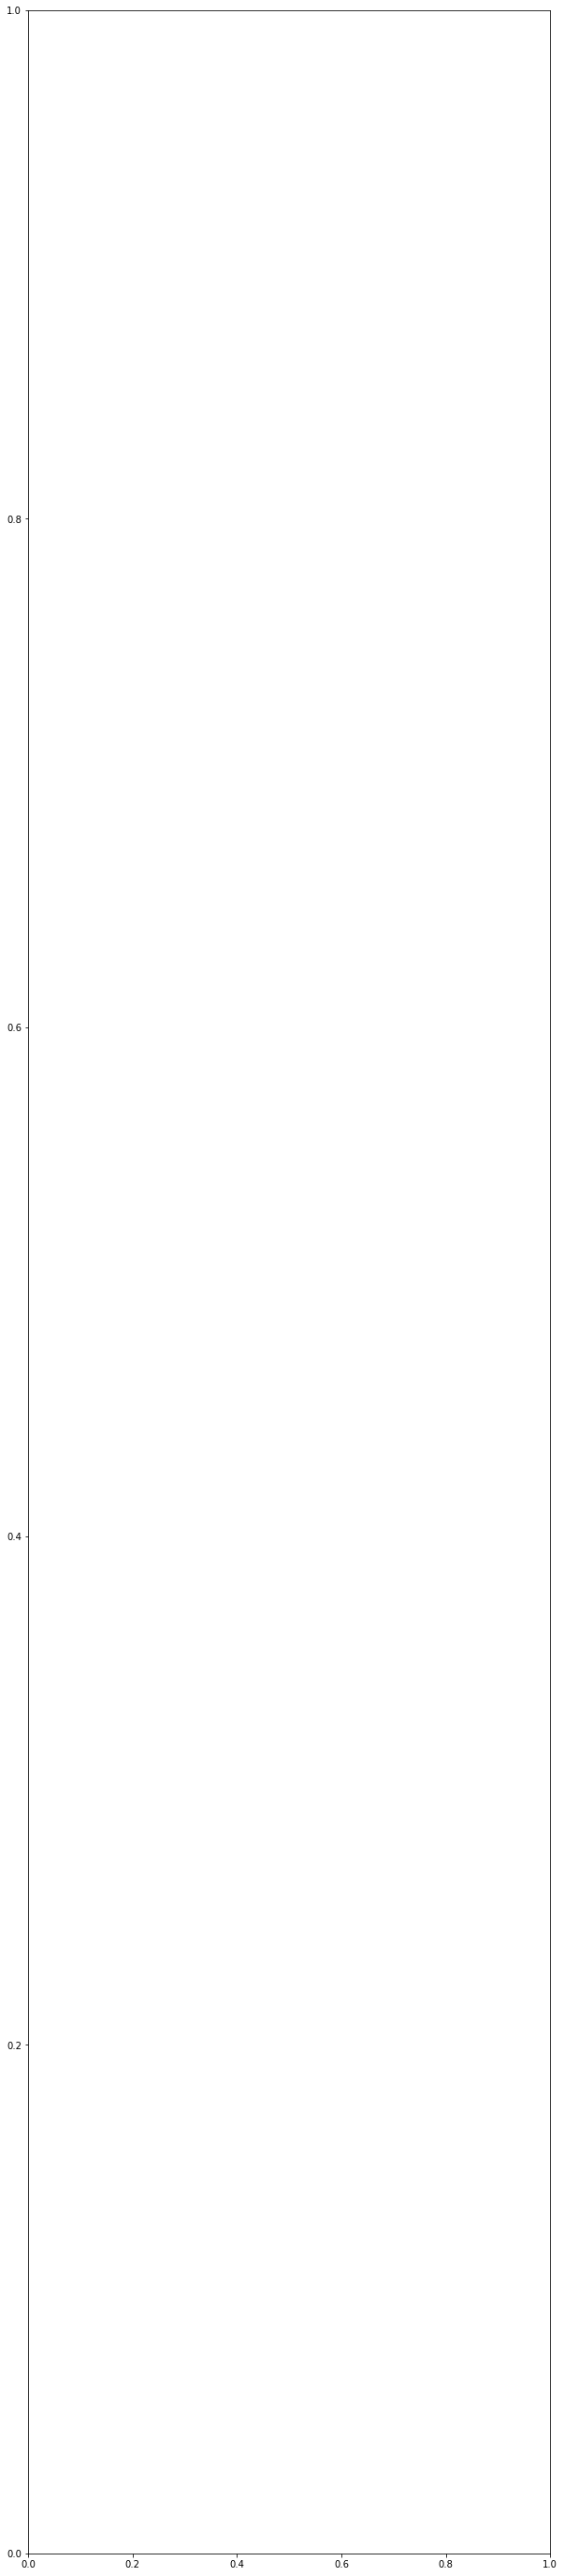

In [74]:
import matplotlib.pyplot as plt 
fea_ = model.feature_importances_
fea_name = model.feature_names_
plt.figure(figsize=(10, 50))
plt.barh(fea_name,fea_,height =0.5)

### 测试集1

In [19]:
train_1 = pd.read_csv('train//is_train_20190730.txt')
y_5 = train_1.label
train_1 = pd.merge(train_1, pro, how='left')
train_1 = train_1.drop('label',1)

### 测试集2

In [16]:
train_1 = pd.read_csv('is_train_data/is_train_20190701.txt')
train_1 = pd.merge(train_1[['link','current_slice_id','future_slice_id']][(train_1.future_slice_id <= 50)],train_1,how='left') 
for i in tqdm(range(25, 31)):
    train1 = pd.read_csv('is_train_data/is_train_201907'+str(i)+'.txt')
    train_1 = train_1.append(pd.merge(train1[['link','current_slice_id','future_slice_id']][(train1.future_slice_id <= 50)],train1,how='left'))

train_1 = pd.merge(train_1, pro, how='left')
y_5 = train_1.label
train_1 = train_1.drop('label',1)
train_1 = train_1.drop('is_high',1)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:23<00:00,  4.00s/it]


In [38]:
train_1 = train_1.drop('pro_0',1)
train_1 = train_1.drop('pro_1',1)
train_1 = train_1.drop('pro_2',1)

In [36]:

train_1 = train_1.drop('current_speed_min',1)
train_1 = train_1.drop('current_eta_min',1)
train_1 = train_1.drop('current_cnt_min',1)
train_1 = train_1.drop('current_state_min',1)

train_1 = train_1.drop('his_28_speed_min',1)
train_1 = train_1.drop('his_28_eta_min',1)
train_1 = train_1.drop('his_28_cnt_min',1)
train_1 = train_1.drop('his_28_state_min',1)

train_1 = train_1.drop('his_21_speed_min',1)
train_1 = train_1.drop('his_21_eta_min',1)
train_1 = train_1.drop('his_21_cnt_min',1)
train_1 = train_1.drop('his_21_state_min',1)

train_1 = train_1.drop('his_14_speed_min',1)
train_1 = train_1.drop('his_14_eta_min',1)
train_1 = train_1.drop('his_14_cnt_min',1)
train_1 = train_1.drop('his_14_state_min',1)

train_1 = train_1.drop('his_7_speed_min',1)
train_1 = train_1.drop('his_7_eta_min',1)
train_1 = train_1.drop('his_7_cnt_min',1)
train_1 = train_1.drop('his_7_state_min',1)


In [23]:
kkk = model.predict(train_1)
print(classification_report(y_5, kkk, digits=4))
report = f1_score(y_5, kkk, average=None)
print('Score: ', report[0] * 0.2 + report[1] * 0.2 + report[2] * 0.6)

              precision    recall  f1-score   support

           0     0.9168    0.9501    0.9332    420969
           1     0.5959    0.5054    0.5469     70524
           2     0.5493    0.4154    0.4731     18921

    accuracy                         0.8689    510414
   macro avg     0.6873    0.6237    0.6511    510414
weighted avg     0.8588    0.8689    0.8627    510414

Score:  0.5798654882282102


In [115]:
kkk = model.predict(train_1)
print(classification_report(y_5, kkk, digits=4))
report = f1_score(y_5, kkk, average=None)
print('Score: ', report[0] * 0.2 + report[1] * 0.2 + report[2] * 0.6)

              precision    recall  f1-score   support

           0     0.9172    0.9488    0.9327    420969
           1     0.6073    0.4740    0.5324     70524
           2     0.4615    0.4845    0.4727     18921

    accuracy                         0.8660    510414
   macro avg     0.6620    0.6358    0.6460    510414
weighted avg     0.8575    0.8660    0.8604    510414

Score:  0.5766737216085995


### 无high

In [54]:
kkk = model.predict(train_1)
print(classification_report(y_5, kkk, digits=4))
report = f1_score(y_5, kkk, average=None)
print('Score: ', report[0] * 0.2 + report[1] * 0.2 + report[2] * 0.6)

              precision    recall  f1-score   support

           0     0.9239    0.9162    0.9200    420969
           1     0.5245    0.4038    0.4563     70524
           2     0.3086    0.6309    0.4145     18921

    accuracy                         0.8348    510414
   macro avg     0.5857    0.6503    0.5969    510414
weighted avg     0.8459    0.8348    0.8372    510414

Score:  0.523958109986195


### 有high

In [27]:
print(classification_report(y_5, model.predict(train_1), digits=4))
report = f1_score(y_5, model.predict(train_1), average=None)
print('Score: ', report[0] * 0.2 + report[1] * 0.2 + report[2] * 0.6)

              precision    recall  f1-score   support

           0     0.8941    0.9515    0.9219    417405
           1     0.6295    0.4061    0.4937     81768
           2     0.4527    0.4934    0.4722     24345

    accuracy                         0.8450    523518
   macro avg     0.6588    0.6170    0.6293    523518
weighted avg     0.8322    0.8450    0.8341    523518

Score:  0.5664538775303181


### 16号预测

In [28]:
 print(classification_report(y_validation, model.predict(X_validation), digits=4))

              precision    recall  f1-score   support

           0     0.9775    1.0000    0.9886      1087
           1     0.0000    0.0000    0.0000        25

    accuracy                         0.9775      1112
   macro avg     0.4888    0.5000    0.4943      1112
weighted avg     0.9555    0.9775    0.9664      1112



In [79]:
num = []
for i in range(504891):
    s = k['linkid_' 'label_' 'current_slice_id_' 'future_slice_id'][i]
    n = len(s)
    k2 = 0
    num2 = []
    cnt = 0
    for j in range(n):
        if s[j] == ' ':
            k2 += 1
            if k2 != 2:
                num2.append(cnt)
            cnt = 0
            continue
        if s[j] == '-': continue
        cnt = cnt * 10 + int(s[j])
        if j == n - 1:
            num2.append(cnt)
    num2.append(3)
    num.append(num2)

In [81]:
num[504890]

[226212, 378, 385, 3]

In [90]:
import csv
f = open(f'f.csv','w',encoding='utf-8',newline='')
csv_writer = csv.writer(f)
csv_writer.writerow(["link","current_slice_id","future_slice_id","label"])
csv_writer.writerows(num)
f.close()

In [43]:
import pycuda.driver as drv

ModuleNotFoundError: No module named 'pycuda'